### Preparations

In [1]:
import numpy as np
from sympy import *
import warnings
from scipy.linalg import solve_continuous_lyapunov
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
init_printing(use_unicode=True)

def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

def create_A_Sigma_sympy(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A_sympy(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

### p = 3
The lower right sub-matrix $B_3$ for p=3, in this case it is a $3\times 3$ matrix.

In [19]:
p = 3
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)

# dismiss factors
A[0, :] = A[0, :] / 2
A[3, :] = A[3, :] / 2
A[5, :] = A[5, :] / 2

# column operations to get "block form"
A[:, 1], A[:, 3] = A[:, 3], A[:, 1]
A[:, 2], A[:, 6] = A[:, 6], A[:, 2]
A[:, 5], A[:, 7] = A[:, 7], A[:, 5]
A

⎡Σ₀₀  Σ₀₁  Σ₀₂   0    0    0    0    0    0 ⎤
⎢                                           ⎥
⎢Σ₀₁  Σ₁₁  Σ₁₂  Σ₀₀  Σ₀₁  Σ₀₂   0    0    0 ⎥
⎢                                           ⎥
⎢Σ₀₂  Σ₁₂  Σ₂₂   0    0    0   Σ₀₀  Σ₀₁  Σ₀₂⎥
⎢                                           ⎥
⎢ 0    0    0   Σ₀₁  Σ₁₁  Σ₁₂   0    0    0 ⎥
⎢                                           ⎥
⎢ 0    0    0   Σ₀₂  Σ₁₂  Σ₂₂  Σ₀₁  Σ₁₁  Σ₁₂⎥
⎢                                           ⎥
⎢ 0    0    0    0    0    0   Σ₀₂  Σ₁₂  Σ₂₂⎥
⎢                                           ⎥
⎢μ₀₀  μ₁₀  μ₂₀   0    0    0    0    0    0 ⎥
⎢                                           ⎥
⎢ 0    0    0   μ₀₀  μ₁₀  μ₂₀   0    0    0 ⎥
⎢                                           ⎥
⎣ 0    0    0    0    0    0   μ₀₀  μ₁₀  μ₂₀⎦

In [20]:
# row operations to leave one entry in first column, two in the second
A[0, :] = A[0, :] - (A[0, 0] / A[6, 0]) * A[6, :]
A[1, :] = A[1, :] - (A[1, 0] / A[6, 0]) * A[6, :]
A[2, :] = A[2, :] - (A[2, 0] / A[6, 0]) * A[6, :]
A[2, :] = A[2, :] - (A[2, 1] / A[0, 1]) * A[0, :]
A[1, :] = A[1, :] - (A[1, 1] / A[0, 1]) * A[0, :]
A

⎡       Σ₀₀⋅μ₁₀                             Σ₀₀⋅μ₂₀                            ↪
⎢ 0   - ─────── + Σ₀₁                     - ─────── + Σ₀₂                      ↪
⎢         μ₀₀                                 μ₀₀                              ↪
⎢                                                                              ↪
⎢                                        ⎛  Σ₀₀⋅μ₂₀      ⎞ ⎛  Σ₀₁⋅μ₁₀      ⎞   ↪
⎢                                        ⎜- ─────── + Σ₀₂⎟⋅⎜- ─────── + Σ₁₁⎟   ↪
⎢                        Σ₀₁⋅μ₂₀         ⎝    μ₀₀        ⎠ ⎝    μ₀₀        ⎠   ↪
⎢ 0          0         - ─────── + Σ₁₂ - ───────────────────────────────────   ↪
⎢                          μ₀₀                       Σ₀₀⋅μ₁₀                   ↪
⎢                                                  - ─────── + Σ₀₁             ↪
⎢                                                      μ₀₀                     ↪
⎢                                                                              ↪
⎢                           

In [21]:
# row operations to leave one entry in first column, two in the second
A[1, :] = A[1, :] - (A[1, 3] / A[7, 3]) * A[7, :]
A[3, :] = A[3, :] - (A[3, 3] / A[7, 3]) * A[7, :]
A[4, :] = A[4, :] - (A[4, 3] / A[7, 3]) * A[7, :]
A[4, :] = A[4, :] - (A[4, 4] / A[3, 4]) * A[3, :]
A[1, :] = A[1, :] - (A[1, 4] / A[3, 4]) * A[3, :]
A

⎡       Σ₀₀⋅μ₁₀                             Σ₀₀⋅μ₂₀                            ↪
⎢ 0   - ─────── + Σ₀₁                     - ─────── + Σ₀₂                      ↪
⎢         μ₀₀                                 μ₀₀                              ↪
⎢                                                                              ↪
⎢                                        ⎛  Σ₀₀⋅μ₂₀      ⎞ ⎛  Σ₀₁⋅μ₁₀      ⎞   ↪
⎢                                        ⎜- ─────── + Σ₀₂⎟⋅⎜- ─────── + Σ₁₁⎟   ↪
⎢                        Σ₀₁⋅μ₂₀         ⎝    μ₀₀        ⎠ ⎝    μ₀₀        ⎠   ↪
⎢ 0          0         - ─────── + Σ₁₂ - ───────────────────────────────────   ↪
⎢                          μ₀₀                       Σ₀₀⋅μ₁₀                   ↪
⎢                                                  - ─────── + Σ₀₁             ↪
⎢                                                      μ₀₀                     ↪
⎢                                                                              ↪
⎢                           

In [22]:
# row operations to leave one entry in first column, two in the second
A[2, :] = A[2, :] - (A[2, 6] / A[8, 6]) * A[8, :]
A[4, :] = A[4, :] - (A[4, 6] / A[8, 6]) * A[8, :]
A[5, :] = A[5, :] - (A[5, 6] / A[8, 6]) * A[8, :]
A[2, :] = A[2, :] - (A[2, 7] / A[5, 7]) * A[5, :]
A[4, :] = A[4, :] - (A[4, 7] / A[5, 7]) * A[5, :]
A

⎡       Σ₀₀⋅μ₁₀                             Σ₀₀⋅μ₂₀                            ↪
⎢ 0   - ─────── + Σ₀₁                     - ─────── + Σ₀₂                      ↪
⎢         μ₀₀                                 μ₀₀                              ↪
⎢                                                                              ↪
⎢                                        ⎛  Σ₀₀⋅μ₂₀      ⎞ ⎛  Σ₀₁⋅μ₁₀      ⎞   ↪
⎢                                        ⎜- ─────── + Σ₀₂⎟⋅⎜- ─────── + Σ₁₁⎟   ↪
⎢                        Σ₀₁⋅μ₂₀         ⎝    μ₀₀        ⎠ ⎝    μ₀₀        ⎠   ↪
⎢ 0          0         - ─────── + Σ₁₂ - ───────────────────────────────────   ↪
⎢                          μ₀₀                       Σ₀₀⋅μ₁₀                   ↪
⎢                                                  - ─────── + Σ₀₁             ↪
⎢                                                      μ₀₀                     ↪
⎢                                                                              ↪
⎢                           

In [27]:
# change column order
A[:, 1], A[:, 3] = A[:, 3], A[:, 1]
A[:, 2], A[:, 6] = A[:, 6], A[:, 2]
A[:, 5], A[:, 7] = A[:, 7], A[:, 5]
A

⎡                 Σ₀₀⋅μ₁₀                                                      ↪
⎢ 0    0    0   - ─────── + Σ₀₁         0                0                     ↪
⎢                   μ₀₀                                                        ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                    Σ₀₁⋅μ₂₀   ↪
⎢ 0    0    0          0                0                0         - ─────── + ↪
⎢                                                                      μ₀₀     ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                           

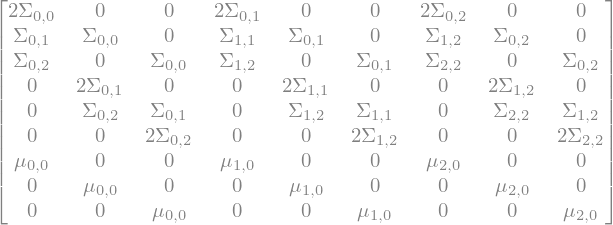

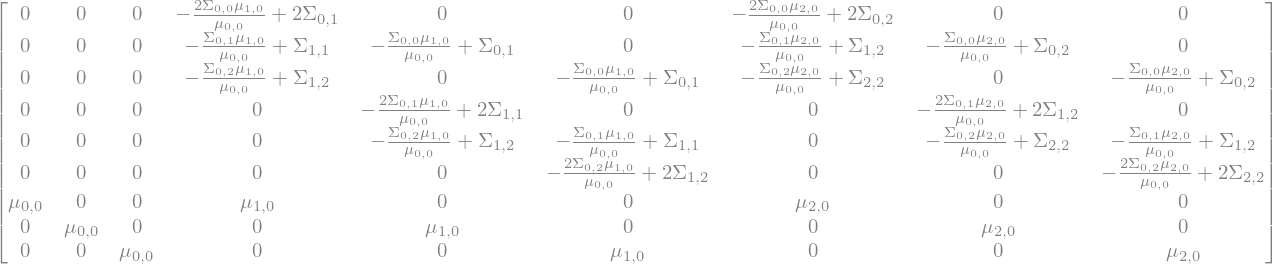

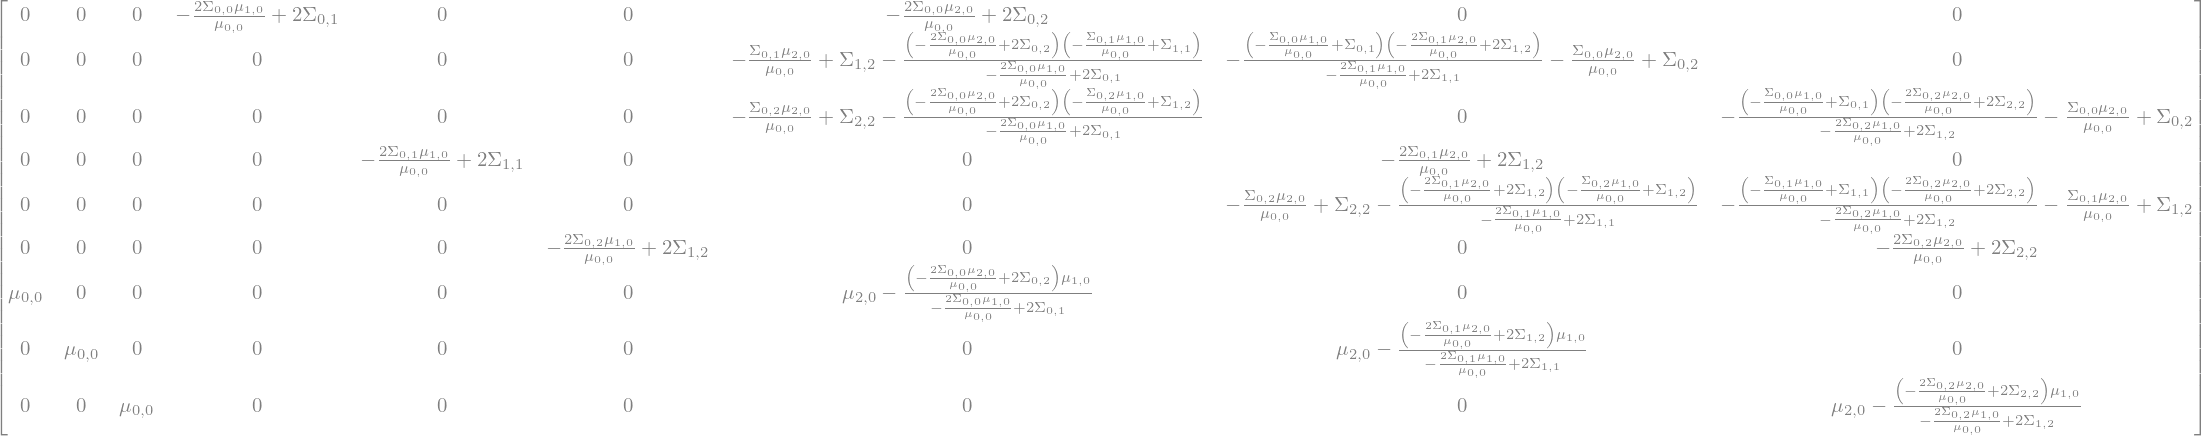

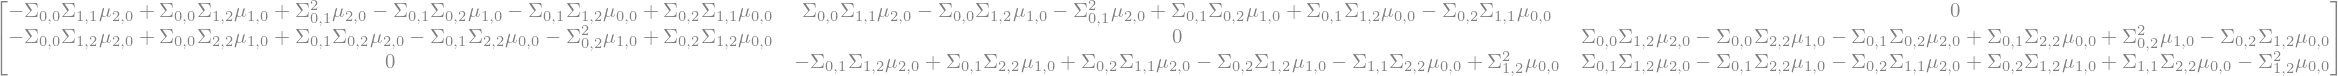

In [26]:
p = 3
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
display(A)

# set first column to 0
A[0, :] = A[0, :] - (A[0, 0] / A[6, 0]) * A[6, :]
A[1, :] = A[1, :] - (A[1, 0] / A[6, 0]) * A[6, :]
A[2, :] = A[2, :] - (A[2, 0] / A[6, 0]) * A[6, :]
# set second column to 0
A[1, :] = A[1, :] - (A[1, 1] / A[7, 1]) * A[7, :]
A[3, :] = A[3, :] - (A[3, 1] / A[7, 1]) * A[7, :]
A[4, :] = A[4, :] - (A[4, 1] / A[7, 1]) * A[7, :]
# set third column to 0
A[2, :] = A[2, :] - (A[2, 2] / A[8, 2]) * A[8, :]
A[4, :] = A[4, :] - (A[4, 2] / A[8, 2]) * A[8, :]
A[5, :] = A[5, :] - (A[5, 2] / A[8, 2]) * A[8, :]
display(A)
# set fourth column to 0
A[1, :] = A[1, :] - (A[1, 3] / A[0, 3]) * A[0, :]
A[2, :] = A[2, :] - (A[2, 3] / A[0, 3]) * A[0, :]
A[6, :] = A[6, :] - (A[6, 3] / A[0, 3]) * A[0, :]
# set fifth column to 0
A[1, :] = A[1, :] - (A[1, 4] / A[3, 4]) * A[3, :]
A[4, :] = A[4, :] - (A[4, 4] / A[3, 4]) * A[3, :]
A[7, :] = A[7, :] - (A[7, 4] / A[3, 4]) * A[3, :]
# set sixth column to 0
A[2, :] = A[2, :] - (A[2, 5] / A[5, 5]) * A[5, :]
A[4, :] = A[4, :] - (A[4, 5] / A[5, 5]) * A[5, :]
A[8, :] = A[8, :] - (A[8, 5] / A[5, 5]) * A[5, :]

display(A)
new_A_3 = A[[1, 2, 4], 6:9] # rank = 2
new_A_3 = simplify(new_A_3).as_mutable()
new_A_3[:, 0] = new_A_3[:, 0] * (cov[0,0]*mean[1,0] - cov[0,1]*mean[0,0])
new_A_3[:, 1] = new_A_3[:, 1] * (cov[1,0]*mean[1,0] - cov[1,1]*mean[0,0])
new_A_3[:, 2] = new_A_3[:, 2] * (cov[2,0]*mean[1,0] - cov[2,1]*mean[0,0])
new_A_3

In [ ]:
new_A_3

### p = 4
The lower right sub-matrix $B_3$ for p=4, in this case it is a $6\times 8$ matrix.

In each row whithin one $p$-Block are, there are only 2 entries and those two have exactly the opposite sign. Adding all columns of a $p$-Block would result in a $0$-vector.

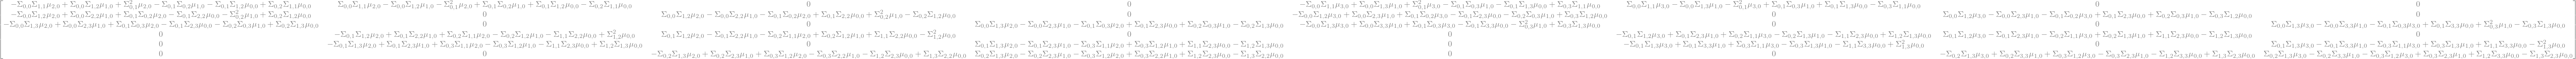

In [3]:
p = 4
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)

# dismiss factors
A[0, :] = A[0, :] / 2
A[4, :] = A[4, :] / 2
A[7, :] = A[7, :] / 2
A[9, :] = A[9, :] / 2

# set first column to 0
A[0, :] = A[0, :] - (A[0, 0] / A[10, 0]) * A[10, :]
A[1, :] = A[1, :] - (A[1, 0] / A[10, 0]) * A[10, :]
A[2, :] = A[2, :] - (A[2, 0] / A[10, 0]) * A[10, :]
A[3, :] = A[3, :] - (A[3, 0] / A[10, 0]) * A[10, :]
# set second column to 0
A[1, :] = A[1, :] - (A[1, 1] / A[11, 1]) * A[11, :]
A[4, :] = A[4, :] - (A[4, 1] / A[11, 1]) * A[11, :]
A[5, :] = A[5, :] - (A[5, 1] / A[11, 1]) * A[11, :]
A[6, :] = A[6, :] - (A[6, 1] / A[11, 1]) * A[11, :]
# set third column to 0
A[2, :] = A[2, :] - (A[2, 2] / A[12, 2]) * A[12, :]
A[5, :] = A[5, :] - (A[5, 2] / A[12, 2]) * A[12, :]
A[7, :] = A[7, :] - (A[7, 2] / A[12, 2]) * A[12, :]
A[8, :] = A[8, :] - (A[8, 2] / A[12, 2]) * A[12, :]
# set fourth column to 0
A[3, :] = A[3, :] - (A[3, 3] / A[13, 3]) * A[13, :]
A[6, :] = A[6, :] - (A[6, 3] / A[13, 3]) * A[13, :]
A[8, :] = A[8, :] - (A[8, 3] / A[13, 3]) * A[13, :]
A[9, :] = A[9, :] - (A[9, 3] / A[13, 3]) * A[13, :]
# set fifth column to 0
A[1, :] = A[1, :] - (A[1, 4] / A[0, 4]) * A[0, :]
A[2, :] = A[2, :] - (A[2, 4] / A[0, 4]) * A[0, :]
A[3, :] = A[3, :] - (A[3, 4] / A[0, 4]) * A[0, :]
A[10, :] = A[10, :] - (A[10, 4] / A[0, 4]) * A[0, :]
# set sixth column to 0
A[1, :] = A[1, :] - (A[1, 5] / A[4, 5]) * A[4, :]
A[5, :] = A[5, :] - (A[5, 5] / A[4, 5]) * A[4, :]
A[6, :] = A[6, :] - (A[6, 5] / A[4, 5]) * A[4, :]
A[11, :] = A[11, :] - (A[11, 5] / A[4, 5]) * A[4, :]
# set seventh column to 0
A[2, :] = A[2, :] - (A[2, 6] / A[7, 6]) * A[7, :]
A[5, :] = A[5, :] - (A[5, 6] / A[7, 6]) * A[7, :]
A[8, :] = A[8, :] - (A[8, 6] / A[7, 6]) * A[7, :]
A[12, :] = A[12, :] - (A[12, 6] / A[7, 6]) * A[7, :]
# set eigth column to 0
A[3, :] = A[3, :] - (A[3, 7] / A[9, 7]) * A[9, :]
A[6, :] = A[6, :] - (A[6, 7] / A[9, 7]) * A[9, :]
A[8, :] = A[8, :] - (A[8, 7] / A[9, 7]) * A[9, :]
A[13, :] = A[13, :] - (A[13, 7] / A[9, 7]) * A[9, :]
# set rows 11, 12, 13, 14 to zero
A[:, 8] = A[:, 8] - (A[10, 8] / A[10, 0]) * A[:, 0]
A[:, 9] = A[:, 9] - (A[11, 9] / A[11, 1]) * A[:, 1]
A[:, 10] = A[:, 10] - (A[12, 10] / A[12, 2]) * A[:, 2]
A[:, 11] = A[:, 11] - (A[13, 11] / A[13, 3]) * A[:, 3]

A[:, 12] = A[:, 12] - (A[10, 12] / A[10, 0]) * A[:, 0]
A[:, 13] = A[:, 13] - (A[11, 13] / A[11, 1]) * A[:, 1]
A[:, 14] = A[:, 14] - (A[12, 14] / A[12, 2]) * A[:, 2]
A[:, 15] = A[:, 15] - (A[13, 15] / A[13, 3]) * A[:, 3]
# set rows 1, 5, 8, 10 to zero
A[:, 8] = A[:, 8] - (A[0, 8] / A[0, 4]) * A[:, 4]
A[:, 9] = A[:, 9] - (A[4, 9] / A[4, 5]) * A[:, 5]
A[:, 10] = A[:, 10] - (A[7, 10] / A[7, 6]) * A[:, 6]
A[:, 11] = A[:, 11] - (A[9, 11] / A[9, 7]) * A[:, 7]
A[:, 12] = A[:, 12] - (A[0, 12] / A[0, 4]) * A[:, 4]
A[:, 13] = A[:, 13] - (A[4, 13] / A[4, 5]) * A[:, 5]
A[:, 14] = A[:, 14] - (A[7, 14] / A[7, 6]) * A[:, 6]
A[:, 15] = A[:, 15] - (A[9, 15] / A[9, 7]) * A[:, 7]

A = simplify(A)
new_A_4 = A[[1, 2, 3, 5, 6, 8], 8:].as_mutable()
new_A_4[:, 0] = new_A_4[:, 0] * (cov[0,0]*mean[1,0] - cov[0,1]*mean[0,0])
new_A_4[:, 4] = new_A_4[:, 4] * (cov[0,0]*mean[1,0] - cov[0,1]*mean[0,0])
new_A_4[:, 1] = new_A_4[:, 1] * (cov[1,0]*mean[1,0] - cov[1,1]*mean[0,0])
new_A_4[:, 5] = new_A_4[:, 5] * (cov[1,0]*mean[1,0] - cov[1,1]*mean[0,0])
new_A_4[:, 2] = new_A_4[:, 2] * (cov[2,0]*mean[1,0] - cov[2,1]*mean[0,0])
new_A_4[:, 6] = new_A_4[:, 6] * (cov[2,0]*mean[1,0] - cov[2,1]*mean[0,0])
new_A_4[:, 3] = new_A_4[:, 3] * (cov[3,0]*mean[1,0] - cov[3,1]*mean[0,0])
new_A_4[:, 7] = new_A_4[:, 7] * (cov[3,0]*mean[1,0] - cov[3,1]*mean[0,0])
new_A_4

### p = 5
The structure of non-zero and zero entries of the lower right sub-matrix $B_3$ for p=5, in this case it is a $10\times 15$ matrix.

The notation with the $\Sigma$ is missleading, all entries look like the ones in the previous matrices.

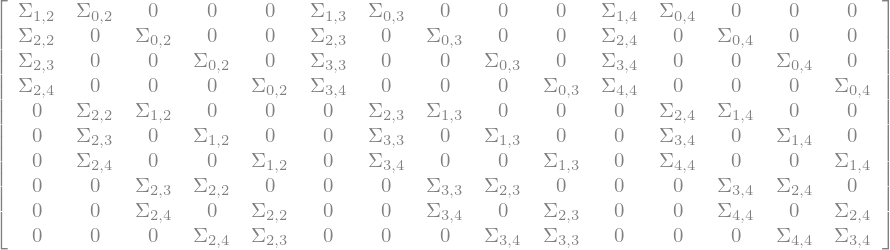

In [4]:
p = 5
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
new_A_5 = A_Sigma[[1, 2, 3, 4, 6, 7, 8, 10, 11, 13], 10:]
new_A_5